In [91]:
sys.path.insert(1, '../heuristics')
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from sqlalchemy import create_engine

from snorkel.labeling import labeling_function

## Load Data

### DataFrame

In [43]:
## load the data by choosing a random 10% of the data
## is the data ordered? am I missing a large chunk due to my partial loading?
# p = 0.01
# responses = pd.read_csv('../data/moralmachine/SharedResponses.csv', skiprows=lambda i: i>0 and random.random() > p)

### SQL Engine

In [44]:
# access SQL DB with data
engine = create_engine("sqlite:///../data/moralmachine.db", echo=False)

In [4]:
# demo
# responses = pd.read_sql("SELECT * FROM sharedresponses ORDER BY RANDOM() LIMIT 100000", con=engine)
# responses.columns

In [5]:
# ## For viewing the possible values for each feature
# for feature in responses.columns:
#     print(feature)
#     print(responses[feature].unique())
#     print(responses[feature].unique().shape)

In [6]:
# ## What does a single user's session/response look like?
# responses_random = responses[responses['ScenarioTypeStrict'] == 'Random']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     ## see a random user's session
# #     display(responses_random[responses_random['ExtendedSessionID'] == responses_random['ExtendedSessionID'].sample().values[0]])
    
#     ## see the user with nth most responses
#     n = 100
#     display(responses_random[responses_random['ResponseID'] == responses_random.groupby(by='ResponseID').size().sort_values(ascending=False).index[n]]) 

In [7]:
# ## group alternatives pairwise!
# # take only responses where both alternatives are present in the random sample - for a full sample, this step isn't necessary
# responses_grouped = responses.groupby(by='ResponseID').filter(lambda g: g.shape[0] < 2)
# responses_grouped.shape

## Data Exploration

In [8]:
# responses.describe()

## Snorkel Labeling
Using https://www.snorkel.org/use-cases/01-spam-tutorial

### Sample Data

In [25]:
# query random sample of responses grouped by ResponseID; only take responses for which both instances are present
sample_size = 10000
query = """
    SELECT gc.session_count, sr.* FROM sharedresponses sr
    INNER JOIN (
        SELECT ExtendedSessionID, COUNT(DISTINCT ResponseID) AS session_count FROM sharedresponses
        WHERE UserID <> ''
        /* Get only full sessions. */
        GROUP BY ExtendedSessionID
            HAVING COUNT(DISTINCT ResponseID) = 13
        LIMIT {0:d}
    ) gc
        ON gc.ExtendedSessionID = sr.ExtendedSessionID
    ORDER BY sr.UserID
""".format(sample_size)
df = pd.read_sql(query, con=engine)
df

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
0,13,4bQxFAyxAPRXojjJu,-1015520950_1003505635996879.0,1003505635996880,13,0,0,0,2,Fat,...,0,0,0,0,0,0,0,0,0,0
1,13,5kFNdbuFrtyQxvaGC,-1015520950_1003505635996879.0,1003505635996880,11,0,1,0,0,Old,...,0,0,0,0,0,0,0,0,0,0
2,13,5tmJZXj8CBeirkpcE,-1015520950_1003505635996879.0,1003505635996880,12,0,0,1,0,High,...,0,0,1,0,0,0,0,0,0,0
3,13,AF9xaFfXtsEhidWWQ,-1015520950_1003505635996879.0,1003505635996880,1,0,1,0,0,Fit,...,0,0,0,0,2,3,0,0,0,0
4,13,4bQxFAyxAPRXojjJu,-1015520950_1003505635996879.0,1003505635996880,13,1,0,1,0,Fit,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245519,13,y9uWeha3LLeRPk9ac,-1006854109_9997973108106382.0,9997973108106380,9,0,0,0,0,Old,...,0,0,0,0,0,0,0,0,0,0
245520,13,yg62SHwAeYMqyoWgS,-1006854109_9997973108106382.0,9997973108106380,11,0,1,0,0,High,...,0,0,0,1,0,0,0,0,0,0
245521,13,rPmgXsbomFEEXZZpn,-1006854109_9997973108106382.0,9997973108106380,10,1,0,1,0,Rand,...,1,1,0,0,0,0,0,1,0,0
245522,13,ubu6vQGbDzTRqScY3,-1006854109_9997973108106382.0,9997973108106380,5,1,0,1,0,Pets,...,0,0,0,0,0,0,0,0,3,2


For comparison to Noothigattu et al., how many pairwise comparisons per voter in this sample dataset?

In [45]:
# number of pairwise comparisons per voter?
# = number of response IDs per voter
df.groupby('UserID')['ResponseID'].nunique().mean()

14.069264069264069

In [46]:
df.columns

Index(['session_count', 'ResponseID', 'ExtendedSessionID', 'UserID',
       'ScenarioOrder', 'Intervention', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Man', 'Woman', 'Pregnant', 'Stroller',
       'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman',
       'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive',
       'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog',
       'Cat'],
      dtype='object')

Out of the variables above, these are the variables that vary within response pairs:
> 'NumberOfCharacters', 'DiffNumberOfCharacters', 'Saved', 'Template', 'DescriptionShown',
'LeftHand', 'UserCountry3', 'Man', 'Woman', 'Pregnant', 'Stroller',
'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman',
'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive',
'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog',
'Cat'

N.B. in each pair of responses, only one is the result of an intervention, and only one is saved. 

In [28]:
df[["ResponseID","Intervention","Saved"]].head()

,ResponseID,Intervention,Saved
0,4bQxFAyxAPRXojjJu,0,0
1,5kFNdbuFrtyQxvaGC,0,0
2,5tmJZXj8CBeirkpcE,0,1
3,AF9xaFfXtsEhidWWQ,0,1
4,4bQxFAyxAPRXojjJu,1,1


### Preprocessing

First, select the fields that are unique to each scenario (the fields that vary within pairs of responses). Then split the dataset into two disjoint sets of alternatives: one in which an intervention occurs, and one in which there is no intervention.

In [29]:
scenario_fields = [
    'ResponseID', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved', 'DescriptionShown', 'LeftHand', 'Man', 'Woman', 'Pregnant', 'Stroller', \
    'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', \
    'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', "CrossingSignal"
]
intervention = df[df['Intervention'] == 1][scenario_fields].set_index('ResponseID')
no_intervention = df[df['Intervention'] == 0][scenario_fields].set_index('ResponseID')

sample_response = df["ResponseID"].sample()
print("Alternative w/ intervention:")
display(intervention.loc[sample_response])
print("Alternative w/o intervention:")
display(no_intervention.loc[sample_response])

Alternative w/ intervention:


,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Saved,DescriptionShown,LeftHand,Man,Woman,Pregnant,Stroller,...,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,CrossingSignal
ResponseID,,,,,,,,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,0,5,4,1,0,0,0,2,0,0,...,1,0,0,1,0,0,1,0,0,0


Alternative w/o intervention:


,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Saved,DescriptionShown,LeftHand,Man,Woman,Pregnant,Stroller,...,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,CrossingSignal
ResponseID,,,,,,,,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,0,1,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Next, combine the datasets on response ID, separating the variable characteristics with suffixes.

In [32]:
df_endo = intervention.join(no_intervention, lsuffix='_int', rsuffix='_noint', how='inner')
df_endo.loc[sample_response]

,Barrier_int,NumberOfCharacters_int,DiffNumberOFCharacters_int,Saved_int,DescriptionShown_int,LeftHand_int,Man_int,Woman_int,Pregnant_int,Stroller_int,...,Criminal_noint,MaleExecutive_noint,FemaleExecutive_noint,FemaleAthlete_noint,MaleAthlete_noint,FemaleDoctor_noint,MaleDoctor_noint,Dog_noint,Cat_noint,CrossingSignal_noint
ResponseID,,,,,,,,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,0,5,4,1,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0


Get data for the columns from the raw data that _didn't_ change within response pairs. Remember to eliminate duplicate response pairs - now that we have a combined tuple for each pairwise comparison, they're no longer necessary.

In [54]:
df_exo = df[[col for col in df.columns if col not in scenario_fields or col == 'ResponseID']].set_index('ResponseID')
df_exo = df_exo.loc[~df_exo.index.duplicated(keep='first')]
df_exo.loc[sample_response]

,session_count,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,DefaultChoiceIsOmission,Template,UserCountry3
ResponseID,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,13,-1034018492_4425660021317941.0,4425660021317940,11,0,1,Less,Utilitarian,Utilitarian,More,Less,0,Desktop,FRA


Then join that data in with the combined endogenous variables to get a full tuple for each pairwise comparison presented to a user.

In [55]:
df_joined = df_exo.join(df_endo, how='inner')
df_joined.loc[sample_response]

,session_count,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,...,Criminal_noint,MaleExecutive_noint,FemaleExecutive_noint,FemaleAthlete_noint,MaleAthlete_noint,FemaleDoctor_noint,MaleDoctor_noint,Dog_noint,Cat_noint,CrossingSignal_noint
ResponseID,,,,,,,,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,13,-1034018492_4425660021317941.0,4425660021317940,11,0,1,Less,Utilitarian,Utilitarian,More,...,0,0,0,0,0,0,1,0,0,0


In [83]:
import utils
importlib.reload(utils)
from utils import characters_all

def pictofy(response):
    crossing_light = ["🔴" if response["CrossingSignal_{}".format(suf)].iloc[0] == 2 else "🟢" if response["CrossingSignal_{}".format(suf)].iloc[0] == 1 else " " for suf in ["noint", "int"]]
    pedped = ["🚧" if response["Barrier_{}".format(s)].iloc[0] == 1 else "🚸" for s in ["noint", "int"]]
    out_string = \
        "What should the self-driving car do? (ScenarioType: {})\n\n".format(response["ScenarioType"].iloc[0] if "ScenarioType" in response.columns else "Unknown") +\
        "\t    🚘 \n" +\
        "\t   |\t\\ \n" +\
        "\t   v \t v\n" +\
        "\t{}{} \t{}{}\n".format(crossing_light[0], *pedped, crossing_light[1]) +\
        "\t NOINT\tINT\t\n"
    for k, s in {"INT": "_int", "NOINT": "_noint"}.items():
        out_dict = {col: response["{}{}".format(col, s)] for col in characters_all}
        out_list = []
        for c, v in out_dict.items():
            for i in range(int(v)):
                out_list.append(c.split("_")[0])
        out_string += "{} saves: \n{}\n".format(k, out_list)
    print(out_string)
    
pictofy(df_joined.loc[sample_response])

What should the self-driving car do? (ScenarioType: Utilitarian)

	    🚘 
	   |	\ 
	   v 	 v
	 🚸 	🚸 
	 NOINT	INT	
INT saves: 
['Woman', 'Woman', 'Criminal', 'FemaleAthlete', 'MaleDoctor']
NOINT saves: 
['MaleDoctor']



How much data did we lose with all these joins? Shouldn't be any - all we're doing is dividing the dataset in half.

In [57]:
print("df: {}".format(df.shape))
print("df_endo: {}".format(df_endo.shape))
print("df_exo: {}".format(df_exo.shape))
print("df_joined: {}".format(df_joined.shape))

df: (245524, 42)
df_endo: (115524, 54)
df_exo: (130000, 14)
df_joined: (115524, 68)


Finally, let's make it easier to interpret the target variable. For each response, we know whether the user chose to save one set of characters (\_int) by intervention, or save another set (\_noint) by not intervening. Let's call that variable "Intervened" to indicate whether or not the user intervened (swerved the AV).

In [58]:
df_joined['Intervened'] = (df_joined['Saved_int'] == 1).astype(int)
df_joined = df_joined.drop(axis='columns', labels=['Saved_{}'.format(s) for s in ['int', 'noint']]+["Intervention"])
df_joined.loc[sample_response]

,session_count,ExtendedSessionID,UserID,ScenarioOrder,PedPed,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,MaleExecutive_noint,FemaleExecutive_noint,FemaleAthlete_noint,MaleAthlete_noint,FemaleDoctor_noint,MaleDoctor_noint,Dog_noint,Cat_noint,CrossingSignal_noint,Intervened
ResponseID,,,,,,,,,,,,,,,,,,,,,
BxJK4gyiWEz4NrFj6,13,-1034018492_4425660021317941.0,4425660021317940,11,1,Less,Utilitarian,Utilitarian,More,Less,...,0,0,0,0,0,1,0,0,0,1


Now choose which features to use:

In [59]:
# include user countries and other metadata or not? decided not - experts writing LFs are trying to decide most moral response, not predict what an individual from a certain background would do
# but if it helps generalization, technically useful... try both?
features = [
    "Intervened", "PedPed", "CrossingSignal_int", "CrossingSignal_noint", 'NumberOfCharacters_int', 'Man_int', 'Woman_int',
    'Pregnant_int', 'Stroller_int', 'OldMan_int', 'OldWoman_int', 'Boy_int',
    'Girl_int', 'Homeless_int', 'LargeWoman_int', 'LargeMan_int',
    'Criminal_int', 'MaleExecutive_int', 'FemaleExecutive_int',
    'FemaleAthlete_int', 'MaleAthlete_int', 'FemaleDoctor_int', 'Barrier_int',
    'MaleDoctor_int', 'Dog_int', 'Cat_int', 'Barrier_noint', 'NumberOfCharacters_noint',
    'Man_noint', 'Woman_noint', 'Pregnant_noint', 'Stroller_noint', 'OldMan_noint', 'OldWoman_noint',
    'Boy_noint', 'Girl_noint', 'Homeless_noint', 'LargeWoman_noint',
    'LargeMan_noint', 'Criminal_noint', 'MaleExecutive_noint',
    'FemaleExecutive_noint', 'FemaleAthlete_noint', 'MaleAthlete_noint',
    'FemaleDoctor_noint', 'MaleDoctor_noint', 'Dog_noint', 'Cat_noint', 
#     "Template", "UserCountry3", 'DescriptionShown_int', 'LeftHand_int', 'DescriptionShown_noint', 'LeftHand_noint'
]
cat_features = [
#     "Template", "UserCountry3"
]
num_features = [
    "PedPed", "CrossingSignal_int", "CrossingSignal_noint", "NumberOfCharacters_int", "NumberOfCharacters_noint", "Man_int", "Man_noint", "Woman_int", "Woman_noint", 
    "Pregnant_int", "Pregnant_noint", "Stroller_int", "Stroller_noint", "OldMan_int", "OldMan_noint", "OldWoman_int", "OldWoman_noint", "Boy_int", "Boy_noint",
    "LargeMan_noint", "LargeMan_int", "Criminal_int", "Criminal_noint", "MaleExecutive_int", "MaleExecutive_noint", "FemaleExecutive_int",
    "FemaleExecutive_noint", "Girl_int", "Girl_noint", "LargeWoman_int", "LargeWoman_noint", "FemaleAthlete_int", "FemaleAthlete_noint",
    "MaleAthlete_int", "MaleAthlete_noint", "FemaleDoctor_int", "FemaleDoctor_noint", "MaleDoctor_int", "MaleDoctor_noint", "Dog_int",
    "Dog_noint", "Cat_int", "Cat_noint", "Homeless_int", "Barrier_noint", "Homeless_noint", "Barrier_int"
#   'DescriptionShown_int', 'LeftHand_int', 'DescriptionShown_noint', 'LeftHand_noint'
]

Now explicitly type cast and deal with NA's or missing values:

In [73]:
# transform numerical data types
df_proc = df_joined.loc[:,features]
# convert to numeric, changing literals to NaN
for f in num_features:
    df_proc.loc[:,f] = pd.to_numeric(df_proc.loc[:,f], errors='coerce')

In [74]:
# are there any nan in the numerical features? usually just one
nan = df_proc[df_proc[num_features].isna().any(axis=1)]
display(nan)
df_proc = df_proc.dropna(axis=0, how='any', subset=num_features)

,Intervened,PedPed,CrossingSignal_int,CrossingSignal_noint,NumberOfCharacters_int,Man_int,Woman_int,Pregnant_int,Stroller_int,OldMan_int,...,LargeMan_noint,Criminal_noint,MaleExecutive_noint,FemaleExecutive_noint,FemaleAthlete_noint,MaleAthlete_noint,FemaleDoctor_noint,MaleDoctor_noint,Dog_noint,Cat_noint
ResponseID,,,,,,,,,,,,,,,,,,,,,
kLh9W7wZkturRtFgk,1,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train/Test Split

A standard train test split for testing:

In [75]:
from sklearn.model_selection import train_test_split

X = df_proc.drop(labels=["Intervened"], axis='columns', inplace=False)
y = df_proc["Intervened"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.2, random_state=1)
display(X_train.head())
display(y_train.head())

,PedPed,CrossingSignal_int,CrossingSignal_noint,NumberOfCharacters_int,Man_int,Woman_int,Pregnant_int,Stroller_int,OldMan_int,OldWoman_int,...,LargeMan_noint,Criminal_noint,MaleExecutive_noint,FemaleExecutive_noint,FemaleAthlete_noint,MaleAthlete_noint,FemaleDoctor_noint,MaleDoctor_noint,Dog_noint,Cat_noint
ResponseID,,,,,,,,,,,,,,,,,,,,,
BkkQJ6wuePt2Cu4Xw,0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YM2EFRpseGc7oSu7B,1,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7wBW372Ltg5527wNJ,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p4MpcxScpA9jFrupD,1,1,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
pgoChch5Gaft22DKT,1,0,0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


ResponseID
BkkQJ6wuePt2Cu4Xw    1
YM2EFRpseGc7oSu7B    1
7wBW372Ltg5527wNJ    1
p4MpcxScpA9jFrupD    0
pgoChch5Gaft22DKT    1
Name: Intervened, dtype: int64

### Labeling Model

Some sample labeling functions, constructed with the help of the effect sizes in the Moral Machine experiment.

In [174]:
import labeling_functions
importlib.reload(labeling_functions)

from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis


lfs = [
    labeling_functions.doctors,
    labeling_functions.utilitarian,
    labeling_functions.utilitarian_anthro,
    labeling_functions.inaction,
    labeling_functions.pedestrians,
    labeling_functions.females,
    labeling_functions.fitness,
    labeling_functions.status,
    labeling_functions.legal,
    labeling_functions.illegal,
    labeling_functions.youth,
    labeling_functions.criminals,
    labeling_functions.homeless,
    labeling_functions.pets,
    labeling_functions.spare_strollers,
    labeling_functions.spare_girl,
    labeling_functions.spare_boy,
    labeling_functions.spare_pregnant
]

def label(lfs, verbose=True):
    applier = PandasLFApplier(lfs=lfs)
    L_train = applier.apply(df=X_train, progress_bar=verbose)
    L_dev = applier.apply(df=X_dev, progress_bar=verbose)
    L_valid = applier.apply(df=X_val, progress_bar=verbose)
    LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=y_dev.values).sort_values("Correct", ascending=False)
    return L_train, L_dev, L_valid
L_train, L_dev, L_valid = label(lfs)


  5%|▍         | 3544/73934 [00:05<01:57, 598.73it/s]

KeyboardInterrupt: 


  5%|▍         | 3581/73934 [00:20<01:57, 598.73it/s]

## Aggregation

Recall that there are no true labels for this problem - really, we're just measuring similarity of the heuristic labels to real voter's responses. 

**Baseline**: majority label voting.

In [77]:
from snorkel.labeling import MajorityLabelVoter

model_majority = MajorityLabelVoter()
preds_train = model_majority.predict(L=L_train)

**Label Model**: Snorkel aggregator. Chooses weights to combine the labeling functions based on learned conditional probabilities.

In [172]:
from snorkel.labeling import LabelModel

# cardinality is num classes
def train_model_label(L_train):
    model_label = LabelModel(cardinality=2, verbose=True)
    model_label.fit(L_train=L_train, n_epochs=500, lr=.001, log_freq=100, seed=1)
    return model_label
model_label = train_model_label(L_train)
pd.DataFrame([[lf.name for lf in lfs], model_label.get_weights()])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,doctors,utilitarian,utilitarian_anthro,inaction,pedestrians,females,fitness,status,legal,illegal,youth,criminals,homeless,pets,spare_strollers,spare_girl,spare_boy,spare_pregnant
1,1,1,0.5,0.501359,0.880504,0.619241,1,0.489744,0.507223,1,0.877784,0.528833,1,1,1,0.788169,1,None


How much does the label model improve on the majority voter?

In [176]:
def label_accuracy(model, L_valid, y_val, verbose=True):
    acc = model.score(L=L_valid, Y=y_val.values, tie_break_policy="random")["accuracy"]
    if verbose: print(f"{str(model)} {'Vote Accuracy:':<25} {acc*100:.1f}")
    return acc

for model in [model_majority, model_label]:
    label_accuracy(model, L_valid, y_val)

MajorityLabelVoter() Vote Accuracy:            65.6
LabelModel() Vote Accuracy:            67.8


### Eye Test - Debugging Label Model

A handy function for viewing pairwise alternatives:

Now, use the label model to create probabilistic labels for the dev set. Rounding off, create binary predictions.

In [162]:
from snorkel.analysis import get_label_buckets

threshold = 0.5
probs_dev = model_label.predict_proba(L=L_dev)
preds_dev = probs_dev >= threshold

Create label buckets for eyeball debugging (groups TP, FP, TN, FN).

In [163]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = pd.crosstab(y_dev.values.astype(bool), preds_dev[:, 1], rownames=['Actual'], colnames=['Predicted'])
print(cm)

buckets = get_label_buckets(y_dev.values, preds_dev[:, 1])

Predicted  False  True 
Actual                 
False       1617    474
True         997   1533


What is the accuracy for each scenario type?

In [147]:
# false negatives
df_fn_dev = X_dev.iloc[buckets[(1, 0)]]
# false positives
df_fp_dev = X_dev.iloc[buckets[(0, 1)]]
df_n_dev = X_dev.iloc[np.concatenate([buckets[(1, 0)], buckets[(0, 1)]])]
# acc = 1 - Neg / Total for each scenario type
acc = 1 - df_joined.loc[df_n_dev.index, 'ScenarioType'].value_counts() / df_joined.loc[X_dev.index, 'ScenarioType'].value_counts()
acc.sort_values()

Gender           0.557783
Social Status    0.571429
Fitness          0.600000
Random           0.622263
Age              0.717060
Utilitarian      0.792102
Species          0.797212
Name: ScenarioType, dtype: float64

#### False Negatives
Here, the user chose to intervene, while the label model did not. 

In [156]:
# get the corresponding posteriori probability for each false negative
df_fn_dev.loc[:,"probability"] = probs_dev[buckets[(1, 0)], 1]
# check out a few
pictofy(df_fn_dev.sample())

What should the self-driving car do? (ScenarioType: Unknown)

	    🚘 
	   |	\ 
	   v 	 v
	 🚸 	🚸 
	 NOINT	INT	
INT saves: 
['Woman', 'LargeWoman']
NOINT saves: 
['Man', 'LargeMan']



Which scenario types does the model tend to get wrong?

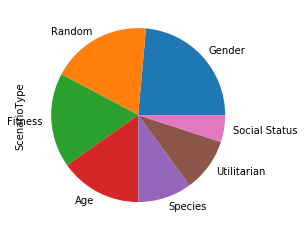

In [128]:
df_joined.loc[df_fn_dev.index, 'ScenarioType'].value_counts().plot.pie()

#### False Positives
Here, the user chose not to intervene, but the label model did.

In [129]:
# get the corresponding posteriori probability for each false positive
df_fp_dev.loc[:,"probability"] = probs_dev[buckets[(0, 1)], 1]
# check out a few
pictofy(df_fp_dev.sample(random_state=3))

What should the self-driving car do? (ScenarioType: Unknown)

	    🚘 
	   |	\ 
	   v 	 v
	 🚧 	🚸🟢
	 NOINT	INT	
INT saves: 
['Criminal']
NOINT saves: 
['Dog']



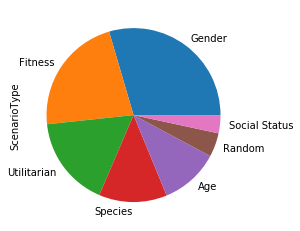

In [130]:
df_joined.loc[df_fp_dev.index, 'ScenarioType'].value_counts().plot.pie()

## Classification

https://www.snorkel.org/use-cases/01-spam-tutorial#5-training-a-classifier

### Featurization

Let's design a simple machine learning classifier for this problem, then test it on both the gold standard labels and the heuristic labels.

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('oh_enc', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
#     ('classifier', LogisticRegression(C=.001))
])

#### Training on Gold Labels

Using just the labels (no label model):

In [137]:
from snorkel.analysis import metric_score

def test_accuracy(clf):
    preds_test_dev = np.round(clf.predict(X_test))
    test_acc = metric_score(golds=y_test, preds=preds_test_dev, metric="accuracy")
    print(f"Test Accuracy: {test_acc * 100:.1f}%")
    
clf.fit(X=X_train, y=y_train)
test_accuracy(clf)

Test Accuracy: 69.6%


#### Training on Heuristic Labels

Using the label model, filter out unlabeled points:

In [144]:
from snorkel.labeling import filter_unlabeled_dataframe

X_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=X_train, y=model_label.predict_proba(L=L_train), L=L_train
)
# check if filtered X_train has same columns
# X_train_filtered.columns == X_train.columns
# how many were filtered?
X_train.shape[0] - X_train_filtered.shape[0]

0

In [145]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)
clf.fit(X=X_train_filtered, y=preds_train_filtered)
test_accuracy(clf)

Test Accuracy: 67.2%


### Grid Search Testing

Which labeling functions add the most predictive performance?

In [ ]:
acc_full = label_accuracy(model_label, L_valid, y_val)
for lf in lfs:
    lfs_perturb = [l for l in lfs if l != lf]
    L_train, L_dev, L_valid = label(lfs_perturb, verbose=False)
    lm = train_model_label(L_train)
    acc_perturb = label_accuracy(lm, L_valid, y_val, verbose=False)
    print("{}: {}".format(lf.name, acc_full - acc_perturb))

LabelModel() Vote Accuracy:            67.8
doctors: 0.0
utilitarian: -0.002488638822765621
utilitarian_anthro: -0.0022181346028997684
inaction: 0.014715429560701154
pedestrians: -0.001839428695087686
females: -0.04712183510062762
fitness: -0.006383899588833564
status: -0.0007033109716512165
legal: -0.0012443194113828104
illegal: -0.0002705042198658525
youth: -0.0036247565462020903
criminals: -0.0007033109716512165
homeless: -0.004273966673880136
pets: -0.000108201687946341
spare_strollers: -0.001406621943302322
